In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
df = pd.read_csv('../data/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
df = df.set_index('Date').sort_index()
df['Price'] = df['Price'].ffill()
df['log_Return'] = np.log(df['Price'] / df['Price'].shift(1))

In [3]:
df.head(15)

,Price,log_Return
Date,,
1987-05-20,18.63,NaN
1987-05-21,18.45,-0.009709
1987-05-22,18.55,0.005405
1987-05-25,18.60,0.002692
1987-05-26,18.63,0.001612
1987-05-27,18.60,-0.001612
1987-05-28,18.60,0.000000
1987-05-29,18.58,-0.001076
1987-06-01,18.65,0.003760


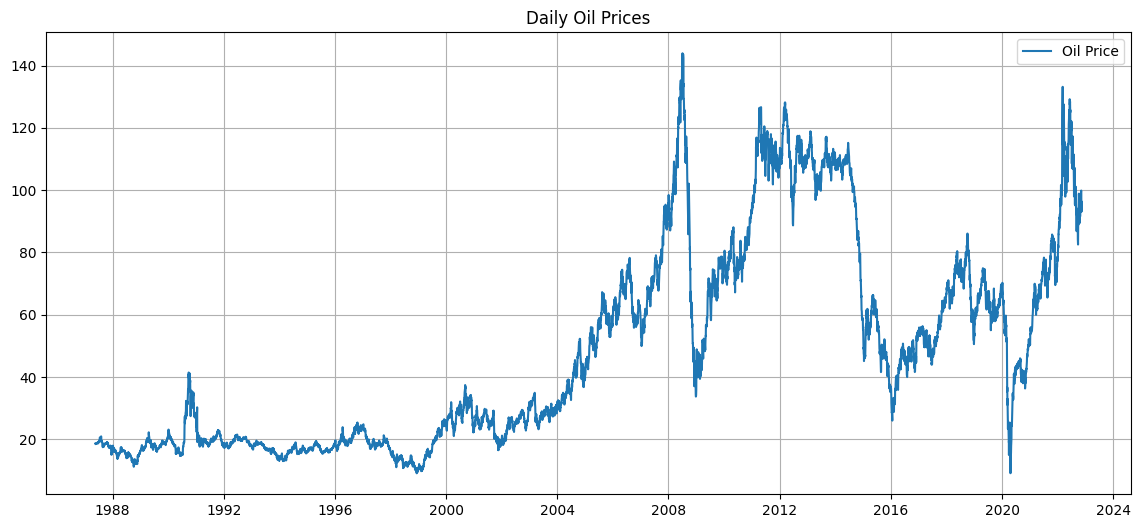

In [4]:
plt.figure(figsize=(14, 6))
plt.plot(df["Price"], label="Oil Price")
plt.title("Daily Oil Prices")
plt.legend()
plt.grid(True)
plt.show()

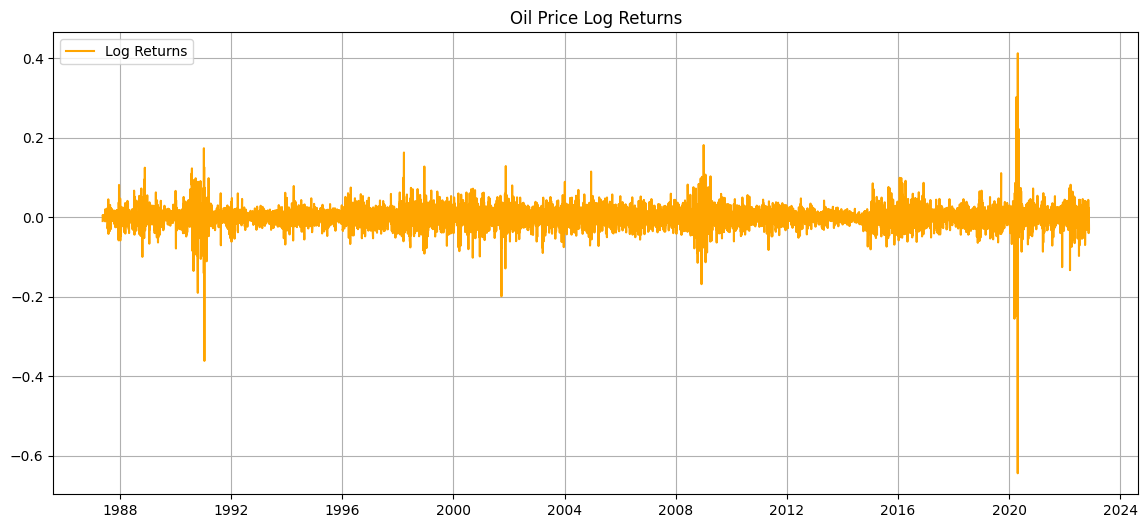

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df["log_Return"], label="Log Returns", color="orange")
plt.title("Oil Price Log Returns")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
result = adfuller(df["log_Return"].dropna())
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")

ADF Statistic: -16.427
p-value: 0.000


In [ ]:
returns = df["log_Return"].dropna().values
N = len(returns)

with pm.Model() as model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=N)

    mu1 = pm.Normal("mu1", mu=0, sigma=1)
    mu2 = pm.Normal("mu2", mu=0, sigma=1)
    sigma1 = pm.HalfNormal("sigma1", sigma=1)
    sigma2 = pm.HalfNormal("sigma2", sigma=1)

    idx = np.arange(N)
    mu = pm.math.switch(tau >= idx, mu1, mu2)
    sigma = pm.math.switch(tau >= idx, sigma1, sigma2)

    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=returns)

    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


Output()